In [1]:
from os import listdir
from os.path import isfile, join
import pandas as pd
import sys
import numpy
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt


In [2]:
PATH = "./"
DATASETS = ["MR","Ohsumed","R8","R52"]

In [3]:
def pretty_print(df):
    # more options can be specified also
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
        print(df) 

In [4]:
def get_metrics(file_path, info, dataset):
    # epochs = 0
    with open(file_path) as f:
        text = f.readlines()
    for line in text:
        if line[0:6] == "Epoch:" :
            epochs = line.split(" ")[1]
        if line[0:17] == "Test set results:":
            tokens = line.split(" ")
            test_result = {
                "cost":tokens[4], 
                "accuracy":tokens[6], 
                "epochs": int(epochs),
                "dataset": dataset,
                "experiment": info[1],
                "name": info[4],
                "run": info[6].split(".")[0]
                }
            return (test_result)

In [5]:
def calculate_basic_statistics(df, dataset):
    # Implment Basic statistics and save as csv
    
    all_results = []
    exp = []
    for i in range(0,19): # This for controls the experiments. Use 25 to get all CUSTOM
        experiment = df.loc[df['experiment'] == i]
        experiment_name = df.loc[df['experiment'] == i]["name"].values[0]
        exp.append(experiment["accuracy"])
        results = {}
        results["experiment"] = i
        results["name"] = experiment_name
        results["min"] = numpy.min(experiment["accuracy"])
        results["max"] = numpy.max(experiment["accuracy"])
        results["mean"] = numpy.mean(experiment["accuracy"])
        results["median"] = numpy.median(experiment["accuracy"])
        results["variance"] = numpy.var(experiment["accuracy"])
        results["standard_deviation"] = numpy.std(experiment["accuracy"])
        results["min_epochs"] = numpy.min(experiment["epochs"])
        results["max_epochs"] = numpy.max(experiment["epochs"])
        results["mean_epochs"] = numpy.mean(experiment["epochs"])
        results["median_epochs"] = numpy.median(experiment["epochs"])
        results["var_epochs"] = numpy.var(experiment["epochs"])
        results["std_epochs"] = numpy.std(experiment["epochs"])
        all_results.append(results)

    results = pd.DataFrame(all_results)
    results.to_csv(
        "./Basic_Statistics/"+dataset+".csv",
        sep=';',
        index=False
    )
    return results

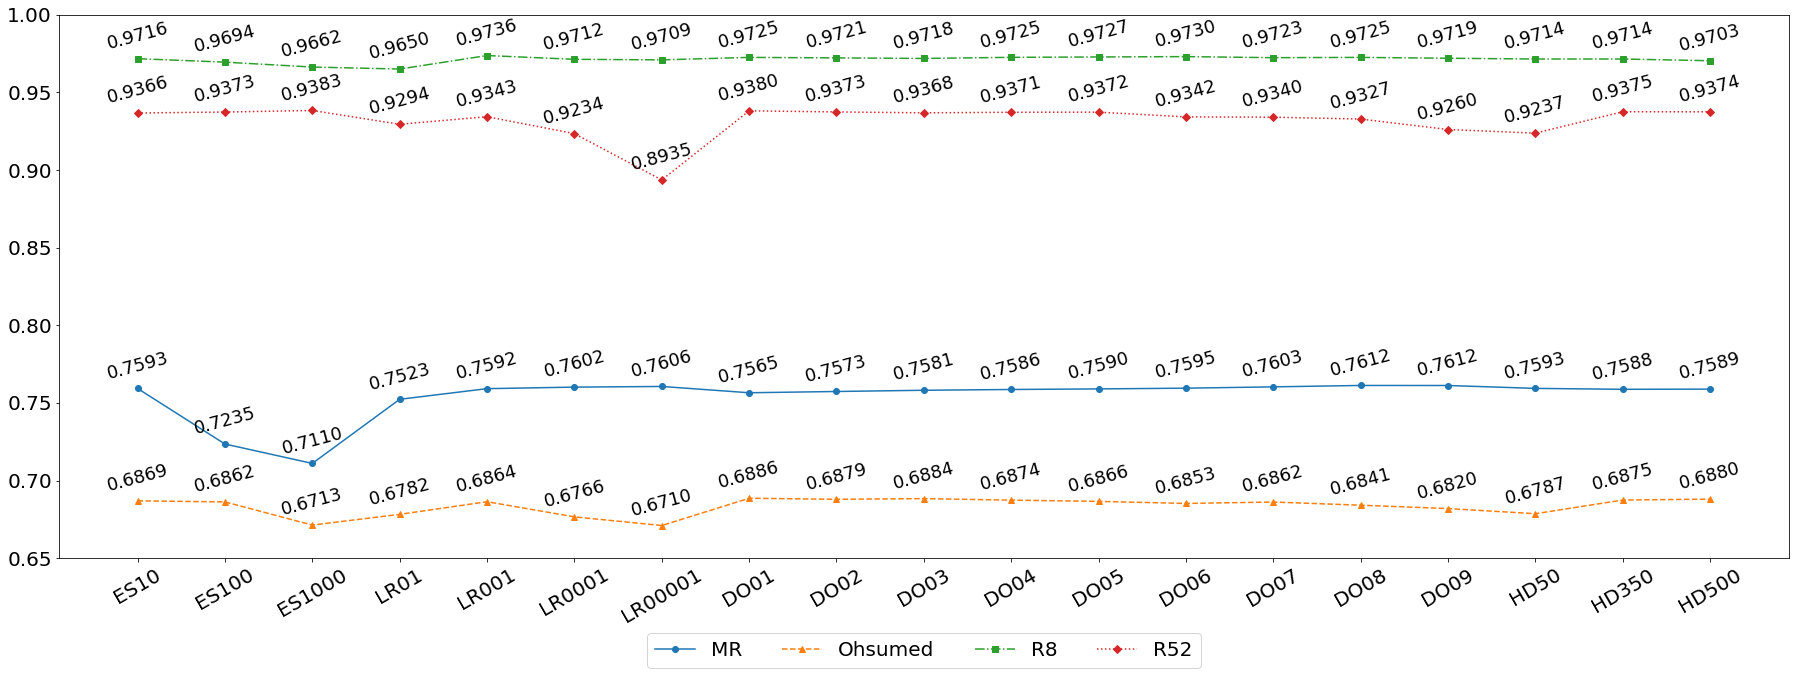

In [95]:
all_results = []
for dataset in DATASETS:
    for run in range(0,10):
        mypath = PATH+dataset+"/RUN_"+str(run)
        onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
        # EXPERIMENT_11_model_mr_DO05_run_6.txt
        for f in onlyfiles:
            info = f.split("_")
            # print(info)
            all_results.append(get_metrics(mypath+"/"+f, info, dataset))

df = pd.DataFrame(data = all_results)

df["cost"] = pd.to_numeric(df["cost"])
df["accuracy"] = pd.to_numeric(df["accuracy"])
df["experiment"] = pd.to_numeric(df["experiment"])
df["run"] = pd.to_numeric(df["run"])

df = df.sort_values(by=['experiment','run','dataset'])
df = df.reset_index(drop=True)

basic_stats = {}
dataset_config = {
    "MR": {"marker":'o', "linestyle":'-'},
    "Ohsumed": {"marker":'^', "linestyle":'--'},
    "R8": {"marker":'s', "linestyle":'-.'},
    "R52": {"marker":'D', "linestyle":':'},
}

plt.figure(figsize=(31, 10))
for dataset in DATASETS:
    experiments = df.loc[df['dataset'] == dataset]
    basic_stats[dataset] = calculate_basic_statistics(experiments, dataset)
    plt.plot(basic_stats[dataset]["name"], basic_stats[dataset]["mean"], marker=dataset_config[dataset]["marker"], linestyle=dataset_config[dataset]["linestyle"], label=dataset)

    for x,y in zip(basic_stats[dataset]["name"],basic_stats[dataset]["mean"]):

        label = "{:.4f}".format(y)

        plt.annotate(label, # this is the text
                    (x,y), # this is the point to label
                    textcoords="offset points", # how to position the text
                    xytext=(0,10), # distance from text to points (x,y)
                    ha='center',  # horizontal alignment can be left, right or center
                    rotation=15,
                    fontsize=18
        )
                    

# plt.title("Average accurracy of each experiment",fontsize=36)
plt.xticks(rotation=30,fontsize=20)
plt.yticks(numpy.arange(0.65, 1.05, step=0.05),fontsize=20)
plt.legend(loc='lower center', fontsize=20,mode=None,ncol=4,bbox_to_anchor=(0.5,-0.22))


plt.show()


In [7]:
def calculate_statistics(max_result, dataset):

    print("------ Working with dataset", dataset, "------\n")
    ORIGINAL_PAPER = {
        "MR": {"avg": 0.7674, "std": 0.0020, "n": 10},
        "Ohsumed": {"avg": 0.6836, "std": 0.0056, "n": 10},
        "R8": {"avg": 0.9707, "std": 0.0010, "n": 10},
        "R52": {"avg": 0.9356, "std": 0.0018, "n": 10}
    }

    # results = pd.DataFrame(all_results)
    # max_result = results.loc[(results["mean"] == numpy.max(results["mean"]))]
    print("The best result is: ", max_result["name"].values[0])
    # print(results)
    # print(max_result)
    OBS = {
        "y1": { # Original paper
            "mean": ORIGINAL_PAPER[dataset]["avg"],
            "std": ORIGINAL_PAPER[dataset]["std"],
            "var": ORIGINAL_PAPER[dataset]["std"] ** 2 ,
            "n": ORIGINAL_PAPER[dataset]["n"]
        },
        "y2":{ # Best result
            "mean": max_result["mean"].values[0],
            "std":  max_result["standard_deviation"].values[0],
            "var": max_result["standard_deviation"].values[0] ** 2,
            "n": 10

        }
    }

    #------- Verify if variance is equal or not
    max_std = numpy.max( [ OBS["y1"]["std"], OBS["y2"]["std"] ])
    min_std = numpy.min( [ OBS["y1"]["std"], OBS["y2"]["std"] ])

    # Guide test: I do not own the tests made by Tao, so I cannot perform levene's test
    IS_VARIANCE_EQUAL = False if ((max_std/min_std) > 2) else True 
    #----------

    if IS_VARIANCE_EQUAL:
        print("Equal Variance")
        degree_of_freedom = OBS["y1"]["n"] + OBS["y2"]["n"] - 2
    else:
        print("Non-equal Variance")
        degree_of_freedom = ( (((OBS["y1"]["var"] / OBS["y1"]["n"]) + (OBS["y2"]["var"] / OBS["y2"]["n"])) ** 2 ) / ((1 / (OBS["y1"]["n"] - 1)) * ((OBS["y1"]["var"]/OBS["y1"]["n"]) ** 2) ) + ((1 / (OBS["y2"]["n"] - 1)) * ((OBS["y2"]["var"]/OBS["y2"]["n"]) ** 2)) ) 

    print("Degree of freedom:", degree_of_freedom)   

    
    ttest_ind_from_stats = stats.ttest_ind_from_stats(
        mean2= max_result["mean"].values[0],
        std2= max_result["standard_deviation"].values[0],
        nobs2= 10,
        mean1=ORIGINAL_PAPER[dataset]["avg"],
        std1=ORIGINAL_PAPER[dataset]["std"],
        nobs1=10,
        equal_var=IS_VARIANCE_EQUAL
    )

    print("")

    # ttest_ind_from_stats:
    # T-test for means of two independent samples from descriptive statistics.
    # This is a two-sided test for the null hypothesis that two independent samples have identical average (expected) values.
    # H0: Mean1 - Mean2 == 0 | Ha: Mean1 - Mean2 != 0

    pvalue = ttest_ind_from_stats.pvalue
    alfa = 0.03
    # print("Alfa: ", alfa)
    # print("pvalue: ", pvalue)
    # print(">>> Level of confidence:", (1-pvalue)*100,"%")
    if pvalue <= alfa :
        print("Reject H0")
        test_result = "Reject H0"
    else:
        print("Fail to reject H0")
        test_result = "Fail to reject H0"
        
    # print(ttest_ind_from_stats)
    print("\n")

# TODO: Estudar Degree of freedom: https://www.investopedia.com/terms/t/t-test.asp 
# https://www.sjsu.edu/faculty/gerstman/StatPrimer/t-table.pdf
    # print(OBS)
    return({
        "Dataset": dataset,
        "Experiment": round(max_result["experiment"].values[0],4) ,
        "Experiment Name": max_result["name"].values[0], 
        "Experiment Mean":round(max_result["mean"].values[0],4), 
        "Experiment Std": round(max_result["standard_deviation"].values[0],4),
        "Original Mean": round(ORIGINAL_PAPER[dataset]["avg"],4),
        "Original Std": round(ORIGINAL_PAPER[dataset]["std"],4),
        "T Test Compared Results": test_result,
        "Alfa": alfa,
        "T-value": round(ttest_ind_from_stats.statistic,4),
        "P-value": pvalue,
        "Level of Confidence (%)": round(((1-pvalue)*100),4),
        "Higher Mean": "Original" if max_result["mean"].values[0] < ORIGINAL_PAPER[dataset]["avg"] else "Experiment" if max_result["mean"].values[0] > ORIGINAL_PAPER[dataset]["avg"] else "Equal",
        "Difference (Experiment-Original)": round(max_result["mean"].values[0] - ORIGINAL_PAPER[dataset]["avg"],4),
        "Equal Variance?": IS_VARIANCE_EQUAL
        })

statistics_results = []
best_results = []

for dataset in DATASETS:
    all_results = basic_stats[dataset]
    for experiment in range(0,19):    
        results = pd.DataFrame(all_results)
        experiment_results = results.loc[(results["experiment"] == experiment)]
        statistics_results.append(calculate_statistics(experiment_results, dataset))
    
    results = pd.DataFrame(all_results)
    max_result = results.loc[(results["mean"] == numpy.max(results["mean"]))]
    best_results.append(calculate_statistics(max_result, dataset))

    

statistics_results_df = pd.DataFrame(statistics_results)
best_results_df = pd.DataFrame(best_results)
print(statistics_results_df)
print(best_results_df)

statistics_results_df.to_csv(
        "./Comparisons/all_results.csv",
        sep=';',
        index=False
    )
best_results_df.to_csv(
        "./Comparisons/best_results.csv",
        sep=';',
        index=False
    )



------ Working with dataset MR ------

The best result is:  ES10
Non-equal Variance
Degree of freedom: 12.344441576423

Reject H0


------ Working with dataset MR ------

The best result is:  ES100
Equal Variance
Degree of freedom: 18

Reject H0


------ Working with dataset MR ------

The best result is:  ES1000
Equal Variance
Degree of freedom: 18

Reject H0


------ Working with dataset MR ------

The best result is:  LR01
Equal Variance
Degree of freedom: 18

Reject H0


------ Working with dataset MR ------

The best result is:  LR001
Equal Variance
Degree of freedom: 18

Reject H0


------ Working with dataset MR ------

The best result is:  LR0001
Non-equal Variance
Degree of freedom: 13.543031127353002

Reject H0


------ Working with dataset MR ------

The best result is:  LR00001
Non-equal Variance
Degree of freedom: 12.039199760025104

Reject H0


------ Working with dataset MR ------

The best result is:  DO01
Equal Variance
Degree of freedom: 18

Reject H0


------ Working

In [8]:
def statistican_test(OBS, dataset):

    # print("------ Working with dataset", dataset, "------\n")

    #------- Verify if variance is equal or not
    max_std = numpy.max( [ OBS["y1"]["std"], OBS["y2"]["std"] ])
    min_std = numpy.min( [ OBS["y1"]["std"], OBS["y2"]["std"] ])

    # Guide test: I do not own the tests made by Tao, so I cannot perform levene's test
    IS_VARIANCE_EQUAL = False if ((max_std/min_std) > 2) else True 
    #----------

    if IS_VARIANCE_EQUAL:
        # print("Equal Variance")
        degree_of_freedom = OBS["y1"]["n"] + OBS["y2"]["n"] - 2
    else:
        # print("Non-equal Variance")
        degree_of_freedom = ( (((OBS["y1"]["var"] / OBS["y1"]["n"]) + (OBS["y2"]["var"] / OBS["y2"]["n"])) ** 2 ) / ((1 / (OBS["y1"]["n"] - 1)) * ((OBS["y1"]["var"]/OBS["y1"]["n"]) ** 2) ) + ((1 / (OBS["y2"]["n"] - 1)) * ((OBS["y2"]["var"]/OBS["y2"]["n"]) ** 2)) ) 

    # print("Degree of freedom:", degree_of_freedom)   

    # print(OBS)
    ttest_ind_from_stats = stats.ttest_ind_from_stats(        
        mean1= OBS['y1']["mean"],
        std1= OBS['y1']["std"],
        nobs1= OBS['y1']['n'],

        mean2= OBS['y2']["mean"],
        std2= OBS['y2']["std"],
        nobs2= OBS['y2']['n'],

        equal_var=IS_VARIANCE_EQUAL        
    )

    # print("")
    # print(ttest_ind_from_stats)
    # ttest_ind_from_stats:
    # T-test for means of two independent samples from descriptive statistics.
    # This is a two-sided test for the null hypothesis that two independent samples have identical average (expected) values.
    # H0: Mean1 - Mean2 == 0 | Ha: Mean1 - Mean2 != 0

    pvalue = ttest_ind_from_stats.pvalue
    alfa = 0.03
    # print("Alfa: ", alfa)
    # print("pvalue: ", pvalue)
    # print(">>> Level of confidence:", (1-pvalue)*100,"%")

    if pvalue <= alfa :
        # print("Reject H0")
        test_result = "Reject H0"
    else:
        # print("Fail to reject H0")
        test_result = "Fail to reject H0"
        
 
    # print("\n")

    

    return({
        "Dataset": dataset,
        "Experiment 1 Name": OBS['y1']["name"], 
        "Experiment 2 Name": OBS['y2']["name"],
        "T Test Compared Results": test_result,
        "Alfa": alfa,
        "T-value": round(ttest_ind_from_stats.statistic,4),
        "P-value": pvalue,
        "Level of Confidence (%)": round(((1-pvalue)*100),4),
        "Equal Variance?": IS_VARIANCE_EQUAL
        })


from itertools import combinations

numbers = list(range(0,19))

comb = list(combinations(numbers, 2))

# print(numbers)
# print(comb)
# print("Len >>", len(comb))

statistics_results_comb = []

for dataset in DATASETS:
    print("Dataset: ", dataset)    
    all_results = basic_stats[dataset]
    # print(all_results)
    for c in comb:    
        results = pd.DataFrame(all_results)
        exp1 = results.loc[(results["experiment"] == c[0])]
        exp2 = results.loc[(results["experiment"] == c[1])]

        OBS = {
            "y1": {
                "mean": exp1["mean"].values[0],
                "std": exp1["standard_deviation"].values[0],
                "var": exp1["standard_deviation"].values[0] ** 2 ,
                "n": 10,
                "name": exp1["name"].values[0]
            },
            "y2":{
                "mean": exp2["mean"].values[0],
                "std": exp2["standard_deviation"].values[0],
                "var": exp2["standard_deviation"].values[0] ** 2 ,
                "n": 10,
                "name": exp2["name"].values[0]
            }
        }
        statistics_results_comb.append(statistican_test(OBS, dataset))

print("Number of combinations >>", len(comb))
print("All number of combinations >> ", len(statistics_results_comb))

statistics_results_comb_df = pd.DataFrame(statistics_results_comb)

statistics_results_comb_df.to_csv(
        "./Comparisons/statistical_results_between_results.csv",
        sep=';',
        index=False
    )

Dataset:  MR
Dataset:  Ohsumed
Dataset:  R8
Dataset:  R52
Number of combinations >> 171
All number of combinations >>  684


In [9]:
rejected = statistics_results_comb_df.loc[(statistics_results_comb_df["T Test Compared Results"] == "Reject H0")]
not_rejected = statistics_results_comb_df.loc[(statistics_results_comb_df["T Test Compared Results"] == "Fail to reject H0")]

print("Rejected H0:", len(rejected))
print("Failed to reject H0:", len(not_rejected))

test_t = []

for dataset in DATASETS:
    test_t.append(
        {
            "Dataset": dataset,            
            "Failed to reject H0": len(not_rejected.loc[(not_rejected["Dataset"] == dataset)]),
            "Rejected H0": len(rejected.loc[(rejected["Dataset"] == dataset)]),
            "Total Tested": len(rejected.loc[(rejected["Dataset"] == dataset)]) + len(not_rejected.loc[(not_rejected["Dataset"] == dataset)])
        }
    )
df_test_t = pd.DataFrame(test_t)
df_test_t.head()



Rejected H0: 436
Failed to reject H0: 248


,Dataset,Failed to reject H0,Rejected H0,Total Tested
0,MR,48,123,171
1,Ohsumed,67,104,171
2,R8,79,92,171
3,R52,54,117,171
